### We aim to train reward models using the DNA enhancers data provided by Gosai et al., 2023. 

## 1- Dataset preprocessing

In [1]:
import pandas as pd
import numpy as np
from grelu.visualize import plot_pred_scatter

import wandb
wandb.login(host="https://api.wandb.ai")

Failed to detect the name of this notebook, you can set it manually with the WANDB_NOTEBOOK_NAME environment variable to enable code saving.
wandb: Currently logged in as: sarosavo. Use `wandb login --relogin` to force relogin


True

***

## 2. Model training

In [2]:
run = wandb.init(entity=None, project='human-mpra-gosai-2023', job_type='training', name='train')
run.name

'train'

### Load the dataset

In [3]:
df = pd.read_csv('artifacts/DNA-dataset:v0/dataset.csv.gz', index_col=0)
df.head()

,chrom,seq,hepg2,k562,sknsh
0,chr7,CCTGGTCTTTCTTGCTAAATAAACATATCGTGCATCATCCAGATCT...,0.233601,0.060779,0.047194
1,chr1,CATAAAGATGAGGCTTGGCAAAGAACATCTCTCGGTGCCTCCCATT...,0.004565,0.379639,-0.244395
2,chr1,CATAAAGCCAATCACTGAGATGACAAGTACTGCCAGGAAAGAAGGC...,0.384537,0.036707,-0.004578
3,chr15,CATAAAGGCAGTGTAGACCCAAACAGTGAGCAGTAGCAAGATTTAT...,4.116494,4.508784,3.040183
4,chr12,CATAAAGGGCTGAACATGCTGTTGAAAAAATGTAGATATAAAAGTT...,1.423444,1.616602,1.335892


### Train/Val/Test split by chromosome

In [4]:
import grelu.data.preprocess

In [5]:
train_chroms = None
val_chroms   = ['chr7']
test_chroms  = ['chr13']

df_train, df_val, df_test = grelu.data.preprocess.split(
    df, 
    train_chroms=train_chroms,
    val_chroms=val_chroms,
    test_chroms=test_chroms,
)

df_train = df_train[['seq', 'hepg2', 'k562', 'sknsh']]
df_val = df_val[['seq', 'hepg2', 'k562', 'sknsh']]

Selecting training samples
Keeping 672966 intervals


Selecting validation samples
Keeping 42631 intervals


Selecting test samples
Keeping 19559 intervals
Final sizes: train: (672966, 5), val: (42631, 5), test: (19559, 5)


### Start the training!

In [6]:
model_params = {
    'model_type':'EnformerPretrainedModel',
    'n_tasks': 3,
    'n_transformers': 3,
}

train_params = {
    'task':'regression',
    'loss': 'MSE',
    'lr':1e-4,
    'logger': 'wandb',
    'batch_size': 512,
    'num_workers': 4,
    'devices': [2],
    'save_dir': 'experiment',
    'optimizer': 'adam',
    'max_epochs': 10,
    'checkpoint': True,
}

In [7]:
import grelu.data.dataset
from grelu.lightning import LightningModel
# Make labeled datasets
train_dataset = grelu.data.dataset.DFSeqDataset(df_train)
val_dataset   = grelu.data.dataset.DFSeqDataset(df_val)

# Build model
model = LightningModel(model_params=model_params, train_params=train_params)

Sequences will be extracted from columns ['seq']
Sequences will be extracted from columns ['seq']


wandb: WARNING Calling wandb.login() after wandb.init() has no effect.
wandb: Downloading large artifact human_state_dict:latest, 939.29MB. 1 files... 
wandb:   1 of 1 files downloaded.  
Done. 0:0:0.7


In [8]:
# Train model
trainer = model.train_on_dataset(train_dataset, val_dataset)
wandb.finish()

GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs


/home/zhaoy183/miniconda3/envs/bioseq/lib/python3.12/site-packages/pytorch_lightning/loggers/wandb.py:396: There is a wandb run already in progress and newly created instances of `WandbLogger` will reuse this run. If this is not desired, call `wandb.finish()` before instantiating `WandbLogger`.
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0,1,2,3,4,5,6,7]


Validation: |          | 0/? [00:00<?, ?it/s]

────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────
     Validate metric           DataLoader 0
────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────
        val_loss             1.426921010017395
         val_mse             1.424808382987976
       val_pearson         -0.14356878399848938
────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────


LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0,1,2,3,4,5,6,7]

  | Name         | Type                    | Params | Mode 
-----------------------------------------------------------------
0 | model        | EnformerPretrainedModel | 103 M  | train
1 | loss         | MSELoss                 | 0      | train
2 | activation   | Identity                | 0      | train
3 | val_metrics  | MetricCollection        | 0      | train
4 | test_metrics | MetricCollection        | 0      | train
5 | transform    | Identity                | 0      | train
-----------------------------------------------------------------
103 M     Trainable params
0         Non-trainable params
103 M     Total params
412.531   Total estimated model params size (MB)


Sanity Checking: |          | 0/? [00:00<?, ?it/s]

/home/zhaoy183/miniconda3/envs/bioseq/lib/python3.12/site-packages/torchmetrics/utilities/prints.py:43: UserWarning: The variance of predictions or target is close to zero. This can cause instability in Pearson correlationcoefficient, leading to wrong results. Consider re-scaling the input if possible or computing using alarger dtype (currently using torch.float32).


Training: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

/home/zhaoy183/miniconda3/envs/bioseq/lib/python3.12/site-packages/pytorch_lightning/trainer/call.py:54: Detected KeyboardInterrupt, attempting graceful shutdown...


epoch,▁▁▁▁▁▁▂▂▂▂▂▂▃▃▃▃▃▃▅▅▅▅▅▅▆▆▆▆▆▆▇▇▇▇▇▇████
train_loss_epoch,█▅▃▂▂▁
train_loss_step,█▆▅▅▄▄▄▃▄▃▃▃▃▃▂▃▃▃▂▃▃▂▃▂▂▂▃▂▂▂▂▂▂▂▂▁▂▁▁▂
trainer/global_step,▁▁▁▂▂▂▂▂▂▃▃▃▃▃▃▄▄▄▄▄▅▅▅▅▅▅▆▆▆▆▆▆▇▇▇▇▇███
val_loss,█▄▃▂▂▁▁
val_mse,█▄▃▂▂▁▁
val_pearson,▁██████
epoch,6
train_loss_epoch,0.20487
train_loss_step,0.17981
trainer/global_step,8849


***

## 3- Test model

In [ ]:
df_test = df_test[['seq', 'hepg2', 'k562', 'sknsh']]
test_dataset = grelu.data.dataset.DFSeqDataset(df_test)
model.test_on_dataset(test_dataset, devices=[1], num_workers=4)

Sequences will be extracted from columns ['seq']


GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
/home/ueharam1/miniconda3/envs/GRELU1/lib/python3.10/site-packages/pytorch_lightning/trainer/connectors/logger_connector/logger_connector.py:75: Starting from v1.9.0, `tensorboardX` has been removed as a dependency of the `pytorch_lightning` package, due to potential conflicts with other packages in the ML ecosystem. For this reason, `logger=True` will use `CSVLogger` as the default logger, unless the `tensorboard` or `tensorboardX` packages are found. Please `pip install lightning[extra]` or one of them to enable TensorBoard support by default
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0,1,2,3,4,5,6,7]


Testing DataLoader 0: 100%|██████████| 77/77 [00:02<00:00, 35.33it/s]
────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────
       Test metric             DataLoader 0
────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────
        test_loss           0.3030757009983063
        test_mse            0.3031761050224304
      test_pearson          0.8466205596923828
────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────


,test_mse,test_pearson
hepg2,0.261059,0.848414
k562,0.331827,0.844957
sknsh,0.316643,0.846490


### Correlation plots for each cell type

In [ ]:
preds = model.predict_on_dataset(test_dataset, devices=[1])

GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0,1,2,3,4,5,6,7]
/home/ueharam1/miniconda3/envs/GRELU1/lib/python3.10/site-packages/pytorch_lightning/trainer/connectors/data_connector.py:424: The 'predict_dataloader' does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` to `num_workers=255` in the `DataLoader` to improve performance.


Predicting DataLoader 0: 100%|██████████| 77/77 [00:01<00:00, 40.49it/s]


### HepG2

/home/ueharam1/miniconda3/envs/GRELU1/lib/python3.10/site-packages/numpy/lib/function_base.py:2889: RuntimeWarning: Degrees of freedom <= 0 for slice
/home/ueharam1/miniconda3/envs/GRELU1/lib/python3.10/site-packages/numpy/lib/function_base.py:2748: RuntimeWarning: divide by zero encountered in divide
/home/ueharam1/miniconda3/envs/GRELU1/lib/python3.10/site-packages/numpy/lib/function_base.py:2748: RuntimeWarning: invalid value encountered in multiply


nan


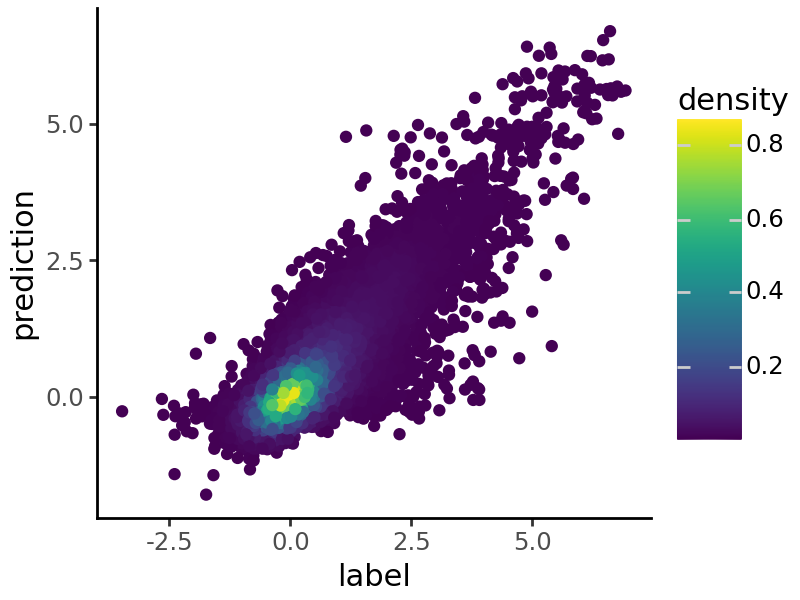

In [ ]:
print(np.corrcoef(preds[:, 0], test_dataset.labels[:, 0])[0][1])
plot_pred_scatter(preds, test_dataset.labels, tasks=[0],  density=True) # hepg2

### K562

/home/ueharam1/miniconda3/envs/GRELU1/lib/python3.10/site-packages/numpy/lib/function_base.py:2889: RuntimeWarning: Degrees of freedom <= 0 for slice
/home/ueharam1/miniconda3/envs/GRELU1/lib/python3.10/site-packages/numpy/lib/function_base.py:2748: RuntimeWarning: divide by zero encountered in divide
/home/ueharam1/miniconda3/envs/GRELU1/lib/python3.10/site-packages/numpy/lib/function_base.py:2748: RuntimeWarning: invalid value encountered in multiply


nan


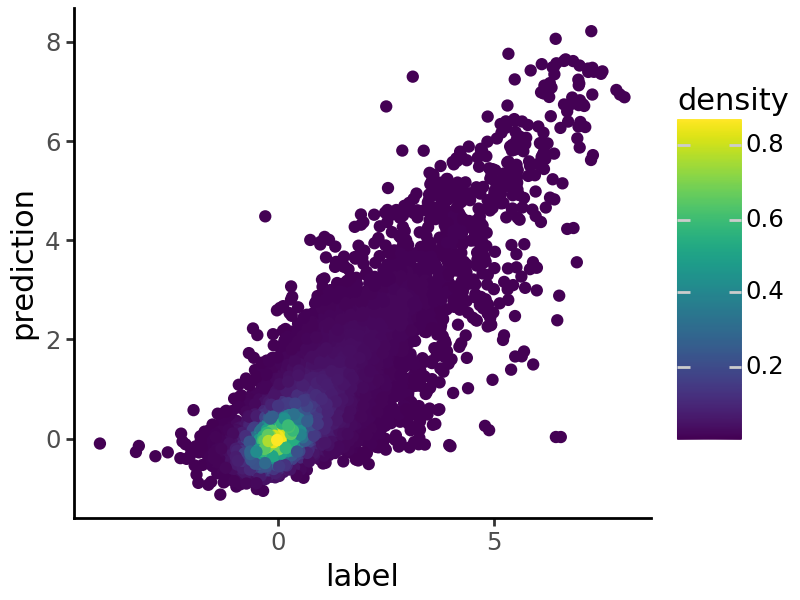

In [ ]:
print(np.corrcoef(preds[:, 1], test_dataset.labels[:, 1])[0][1])
plot_pred_scatter(preds, test_dataset.labels, tasks=[1], density=True) # k562

### SKNSH

/home/ueharam1/miniconda3/envs/GRELU1/lib/python3.10/site-packages/numpy/lib/function_base.py:2889: RuntimeWarning: Degrees of freedom <= 0 for slice
/home/ueharam1/miniconda3/envs/GRELU1/lib/python3.10/site-packages/numpy/lib/function_base.py:2748: RuntimeWarning: divide by zero encountered in divide
/home/ueharam1/miniconda3/envs/GRELU1/lib/python3.10/site-packages/numpy/lib/function_base.py:2748: RuntimeWarning: invalid value encountered in multiply


nan


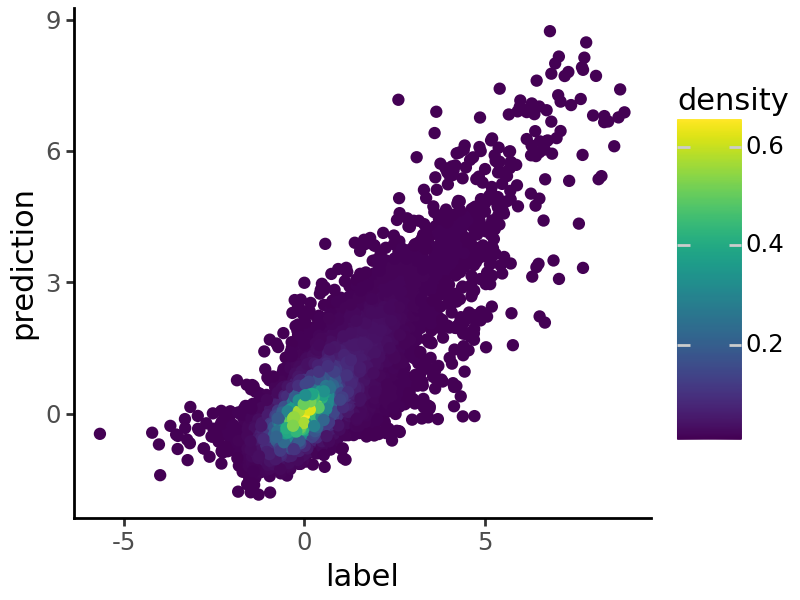

In [ ]:
print(np.corrcoef(preds[:, 2], test_dataset.labels[:, 2])[0][1])
plot_pred_scatter(preds, test_dataset.labels, tasks=[2], density=True) # sknsh